In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import random
import os

SEED = 42
random.seed(SEED)           # Seed for Python's random module
np.random.seed(SEED)        # Seed for NumPy
tf.random.set_seed(SEED)    # Seed for TensorFlow

# Ensure TensorFlow operations are deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load and preprocess the data
data = pd.read_csv("model_data.csv")
data = data.drop(columns=['Unnamed: 0'])
X = data.drop(columns=['target_cost'])
y = data['target_cost']

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data into training, validation, test sets
# 80%:10%:10% ~roughly
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(12/57), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:

# Define the model
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
                               activation='relu'))
        
    model.add(layers.Dense(1))
    
    rates = [0.01, 0.001, 0.0001]

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', rates)),
                  loss='mse',
                  metrics=['mae'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=30,
    executions_per_trial=2,
    directory='model_dir',
    project_name='target_cost_tuning'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model on the full training data
history = best_model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]), epochs=1500, batch_size=32, validation_data=(X_val, y_val))

# Save the model
best_model.save("best_model.keras")


Reloading Tuner from model_dir\target_cost_tuning\tuner0.json
Epoch 1/1500
2/2 [==============================] - 0s 113ms/step - loss: 1302672128.0000 - mae: 20529.9141 - val_loss: 1702721152.0000 - val_mae: 24872.6406
Epoch 2/1500
2/2 [==============================] - 0s 26ms/step - loss: 1280103552.0000 - mae: 20763.0664 - val_loss: 1641249664.0000 - val_mae: 25267.7324
Epoch 3/1500
2/2 [==============================] - 0s 25ms/step - loss: 1256840704.0000 - mae: 21013.2578 - val_loss: 1580359040.0000 - val_mae: 25663.1016
Epoch 4/1500
2/2 [==============================] - 0s 25ms/step - loss: 1226043520.0000 - mae: 21210.4902 - val_loss: 1523233664.0000 - val_mae: 26016.9375
Epoch 5/1500
2/2 [==============================] - 0s 27ms/step - loss: 1214062720.0000 - mae: 21546.4434 - val_loss: 1465549184.0000 - val_mae: 26388.8906
Epoch 6/1500
2/2 [==============================] - 0s 25ms/step - loss: 1190176128.0000 - mae: 21833.9512 - val_loss: 1413870720.0000 - val_mae: 26717.

1/1 [==============================] - 0s 42ms/step
Test MAE: 70944.20916544595
Test MSE: 8435683932.843507
Test RMSE: 91845.97940489015
Test R^2: -5.184505591538222
Test MAPE: 3.013538237903622


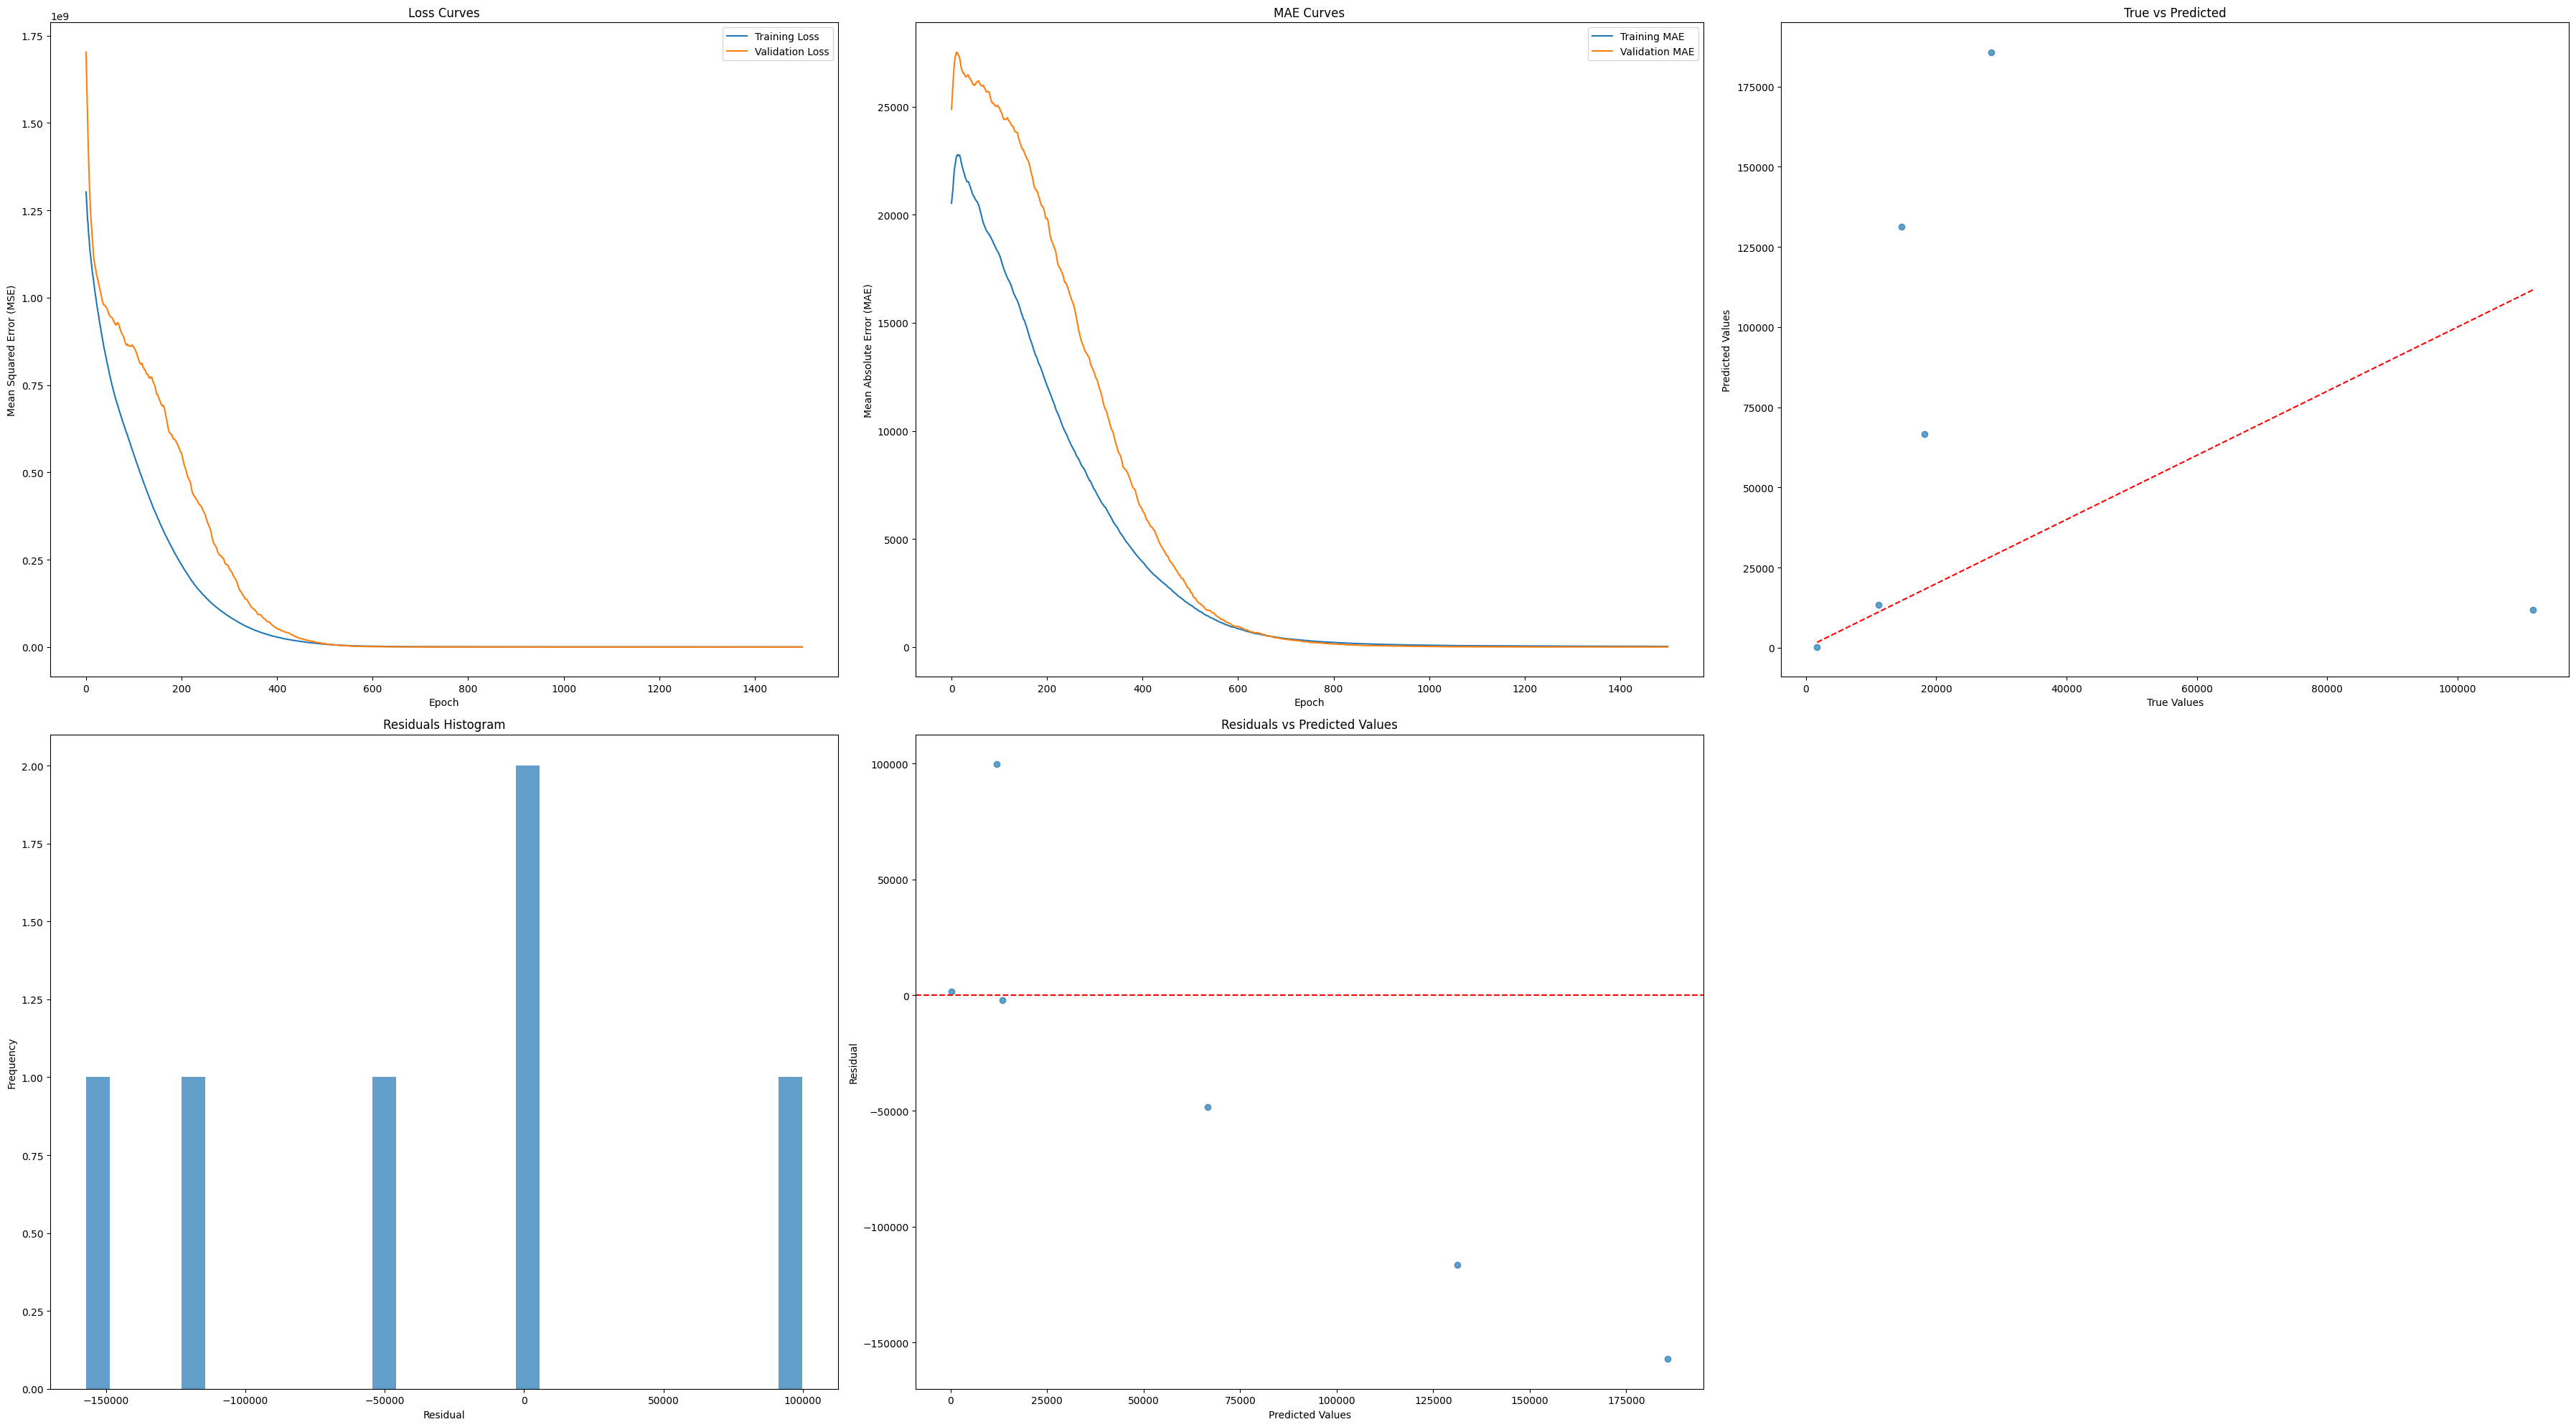

In [8]:

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
residuals = y_test - y_pred.squeeze()

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)
print("Test MAPE:", mape)

# Plotting
plt.figure(figsize=(36, 20))

# Loss Curves
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# MAE Curves
plt.subplot(2, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

# True vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')

# Residuals Histogram
plt.subplot(2, 3, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')

# Residuals Plot
plt.subplot(2, 3, 5)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()


In [9]:
# Predictions
y_preds = best_model.predict(X_test)

y_preds.flatten()


1/1 [==============================] - 0s 22ms/step


array([   243.45966,  11871.058  ,  13400.721  , 185697.8    ,
       131278.47   ,  66658.586  ], dtype=float32)

In [10]:
y_test

47      1700.0
12    111600.0
0      11191.0
45     28490.1
55     14657.8
30     18216.9
Name: target_cost, dtype: float64